# Temporal Analysis

What happens over time?

## Setup

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from bookgender.config import db_uri

## Load the Data

In [4]:
az_rates = pd.read_parquet('data/AZ/ratings.parquet')
print('sorting amazon ratings')
az_rates.sort_values('timestamp', inplace=True)
print('timestampifying Amazon actions')
az_rates['timestamp'] = pd.to_datetime(az_rates['timestamp'], unit='s')
az_rates.info()

sorting amazon ratings
timestampifying Amazon actions
<class 'pandas.core.frame.DataFrame'>
Int64Index: 22464284 entries, 6941990 to 21090668
Data columns (total 4 columns):
user         int64
item         int64
rating       float64
timestamp    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 856.9 MB


In [5]:
gr_rates = pd.read_parquet('data/GR-I/ratings.parquet')
gr_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188962927 entries, 0 to 188962926
Data columns (total 5 columns):
user          int64
item          int64
nactions      int64
first_time    int64
last_time     int64
dtypes: int64(5)
memory usage: 7.0 GB


In [6]:
print('sorting GoodReads actions')
gr_rates.sort_values('first_time', inplace=True)
print('timestampifying GoodReads actions')
gr_rates['timestamp'] = pd.to_datetime(gr_rates['first_time'], unit='s')
gr_rates.info()

sorting GoodReads actions
timestampifying GoodReads actions
<class 'pandas.core.frame.DataFrame'>
Int64Index: 188962927 entries, 26747886 to 184734437
Data columns (total 6 columns):
user          int64
item          int64
nactions      int64
first_time    int64
last_time     int64
timestamp     datetime64[ns]
dtypes: datetime64[ns](1), int64(5)
memory usage: 9.9 GB


Load the gender info:

In [7]:
gender = pd.read_parquet('data/author-gender.parquet')
gender = gender.set_index('item')['gender']
gender[gender.str.startswith('no-')] = 'unlinked'
gender = gender.astype('category')
gender.describe()

count     10735373
unique           5
top       unlinked
freq       4505196
Name: gender, dtype: object

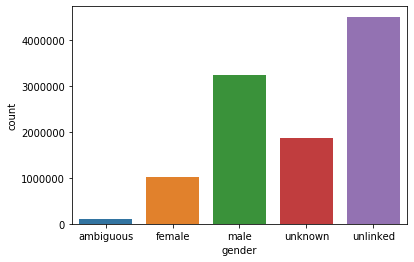

In [42]:
sns.countplot(gender)

In [8]:
az_j = az_rates.set_index('timestamp')[['user', 'item']].join(gender, on='item', how='left')
az_j['gender'].fillna('unlinked', inplace=True)

In [9]:
gr_j = gr_rates.set_index('timestamp')[['user', 'item']].join(gender, on='item', how='left')
gr_j['gender'].fillna('unlinked', inplace=True)

## Evolution over Time

In [10]:
az_counts = az_j.resample('1M')['item'].count()
az_counts.head()

timestamp
1996-05-31    2
1996-06-30    3
1996-07-31    0
1996-08-31    1
1996-09-30    1
Freq: M, Name: item, dtype: int64

In [11]:
gr_counts = gr_j.resample('1M')['item'].count()
gr_counts.head()

timestamp
2006-08-31     18
2006-09-30     12
2006-10-31     12
2006-11-30     13
2006-12-31    299
Freq: M, Name: item, dtype: int64

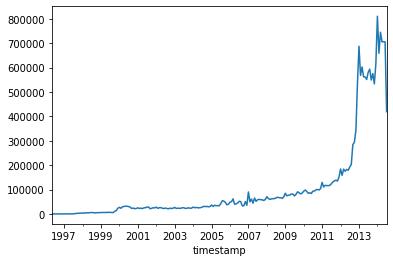

In [12]:
az_counts.plot()

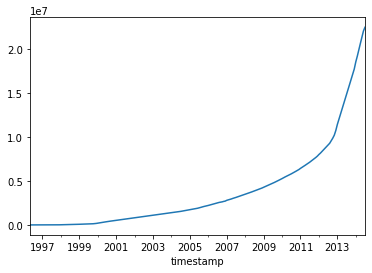

In [43]:
az_counts.cumsum().plot()

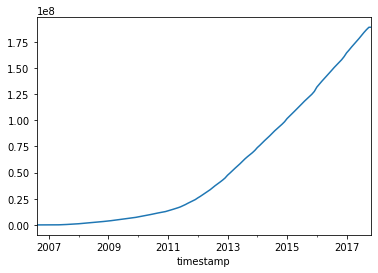

In [13]:
gr_counts.cumsum().plot()

In [14]:
az_gcounts = az_j.resample('1M').apply(lambda df: df.groupby('gender')['item'].count())
az_gcounts.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
1996-05-31,0,0,2,0,0
1996-06-30,0,0,3,0,0
1996-07-31,0,0,0,0,0
1996-08-31,0,1,0,0,0
1996-09-30,0,0,1,0,0


In [15]:
gr_gcounts = gr_j.resample('1M').apply(lambda df: df.groupby('gender')['item'].count())
gr_gcounts.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
2006-08-31,3,1,12,2,0
2006-09-30,2,1,9,0,0
2006-10-31,3,0,9,0,0
2006-11-30,0,4,7,2,0
2006-12-31,28,36,230,1,4


In [16]:
az_gcc = az_gcounts.cumsum()
az_gcc.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
1996-05-31,0,0,2,0,0
1996-06-30,0,0,5,0,0
1996-07-31,0,0,5,0,0
1996-08-31,0,1,5,0,0
1996-09-30,0,1,6,0,0


In [17]:
gr_gcc = gr_gcounts.cumsum()
gr_gcc.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
2006-08-31,3,1,12,2,0
2006-09-30,5,2,21,2,0
2006-10-31,8,2,30,2,0
2006-11-30,8,6,37,4,0
2006-12-31,36,42,267,5,4


In [18]:
az_cc = az_counts.cumsum()

Look at # of ratings over time:

In [19]:
def stack(df, ax=plt):
    ax.stackplot(df.index, df.T, labels=df.columns)
    ax.legend()

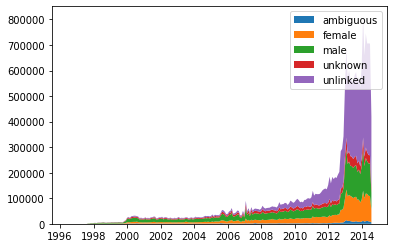

In [20]:
stack(az_gcounts)

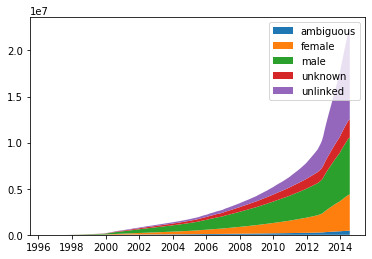

In [21]:
stack(az_gcc)

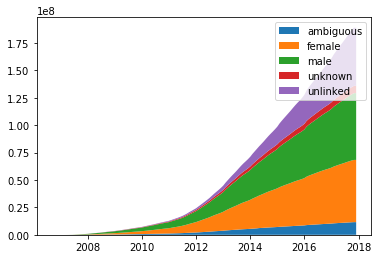

In [22]:
stack(gr_gcc)

And fraction:

In [23]:
az_gfrac = az_gcounts.divide(az_counts, axis=0).dropna()
az_gfrac.head()

gender,ambiguous,female,male,unknown,unlinked
timestamp,,,,,
1996-05-31,0.0,0.000000,1.000000,0.0,0.0
1996-06-30,0.0,0.000000,1.000000,0.0,0.0
1996-08-31,0.0,1.000000,0.000000,0.0,0.0
1996-09-30,0.0,0.000000,1.000000,0.0,0.0
1996-11-30,0.0,0.166667,0.833333,0.0,0.0


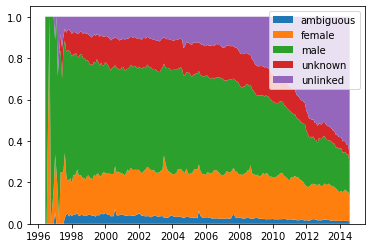

In [24]:
stack(az_gfrac)

Fraction of Known:

In [25]:
az_k = az_gcounts[['female', 'male']]
az_kfrac = az_k.divide(az_k.sum(axis=1), axis=0).dropna()
az_kfrac.head()

gender,female,male
timestamp,,
1996-05-31,0.000000,1.000000
1996-06-30,0.000000,1.000000
1996-08-31,1.000000,0.000000
1996-09-30,0.000000,1.000000
1996-11-30,0.166667,0.833333


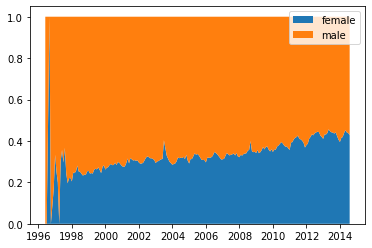

In [26]:
stack(az_kfrac)

Cumulative fractions:

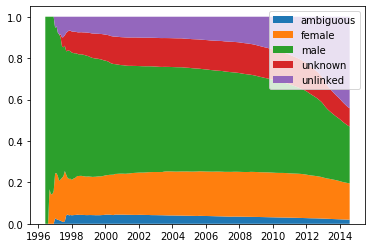

In [27]:
az_cf = az_gcc.divide(az_cc, axis=0)
stack(az_cf)

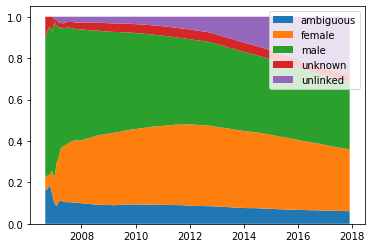

In [28]:
gr_cf = gr_gcc.divide(gr_counts.cumsum(), axis=0)
stack(gr_cf)

In [29]:
az_kcf = az_k.cumsum().divide(az_k.sum(axis=1).cumsum(), axis=0).dropna()
az_kcf.head()

gender,female,male
timestamp,,
1996-05-31,0.000000,1.000000
1996-06-30,0.000000,1.000000
1996-07-31,0.000000,1.000000
1996-08-31,0.166667,0.833333
1996-09-30,0.142857,0.857143


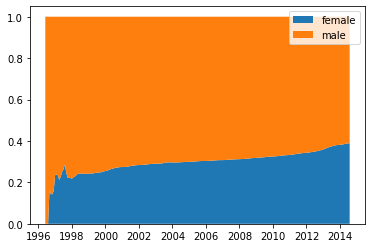

In [30]:
stack(az_kcf)

In [31]:
gr_k = gr_gcounts[['female', 'male']]
gr_kcf = gr_k.cumsum().divide(gr_k.sum(axis=1).cumsum(), axis=0).dropna()
gr_kcf.head()

gender,female,male
timestamp,,
2006-08-31,0.076923,0.923077
2006-09-30,0.086957,0.913043
2006-10-31,0.062500,0.937500
2006-11-30,0.139535,0.860465
2006-12-31,0.135922,0.864078


## Books over Time

In [34]:
book_year = pd.read_sql('''
    SELECT cluster AS item, min(pub_year) AS pub_year
    FROM locmds.book_pub_year
    JOIN locmds.book_rec_isbn USING (rec_id)
    JOIN isbn_cluster USING (isbn_id)
    GROUP BY cluster
''', db_uri())
book_year.head()

,item,pub_year
0,201761454,2008
1,114293136,1982
2,113908707,1984
3,111276590,2003
4,101891138,2006


In [35]:
book_yg = book_year.join(gender, on='item', how='left')
book_yg['gender'].fillna('unknown', inplace=True)
book_yg['pub_year'] = book_yg['pub_year'].astype('i4')
book_yg.head()

,item,pub_year,gender
0,201761454,2008,male
1,114293136,1982,male
2,113908707,1984,unknown
3,111276590,2003,unknown
4,101891138,2006,female


In [36]:
book_yg = book_yg[book_yg.pub_year < 2015]
book_yg = book_yg[book_yg.pub_year > 1960]

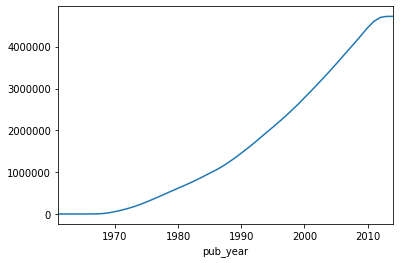

In [37]:
y_counts = book_yg.groupby('pub_year').item.count()
y_counts.cumsum().plot()

In [38]:
y_gc = book_yg.groupby(['pub_year', 'gender']).item.count().unstack()
y_gc.head()

gender,ambiguous,female,male,unknown,unlinked
pub_year,,,,,
1961,10,14,123,15,19
1962,5,22,142,28,30
1963,12,19,180,27,26
1964,8,36,165,25,45
1965,13,28,216,48,47


In [39]:
y_gcc = y_gc.cumsum()
y_gcf = y_gcc.divide(y_counts.cumsum(), axis=0)
y_gcf.head()

gender,ambiguous,female,male,unknown,unlinked
pub_year,,,,,
1961,0.055249,0.077348,0.679558,0.082873,0.104972
1962,0.036765,0.088235,0.649510,0.105392,0.120098
1963,0.040179,0.081845,0.662202,0.104167,0.111607
1964,0.036803,0.095689,0.641430,0.099895,0.126183
1965,0.036838,0.091328,0.633922,0.109747,0.128166


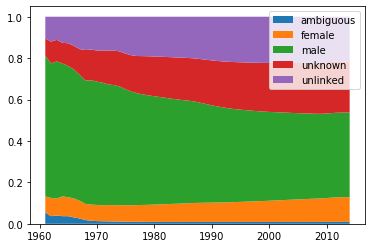

In [40]:
stack(y_gcf)